# <center> **Deep Learning: Supervised Seafloor classification with CNN** </center>
## <center> Machine Learning Programming Exercise 8 part 2.1: **From scratch**</center>

| <font size=6,font color='red'>Monôme / binôme</font> | <font size=6,font color='red'>Nom</font> | <font size=6,font color='red'>Prénom</font> |
|:-------------: |:----------- |:------ |
| binôme 1 | <span style="color:red">DUBEE</span> | <span style="color:red">Melvin</span> |
| binôme 2 | <span style="color:red">ROUDAUT</span> | <span style="color:red">Tanguy</span> |


Vous proposerez une architecture de réseau profond convolutif, apprendrez le modèle avec les patchs et évaluerez ses performances.
- Expliquez votre architecture et en particulier à quoi servent les couches (et leur enchainement) de votre architecture.
- Vous comparerez ensuite les performances obtenus (par rapport à celles obtenues à la partie précédente) sur la matrice de confusion et les métriques de performance classiques.

- Suivre les différentes étapes du tuto.
- **remarque**: comme les images sonar sont en niveaux de gris, il s'agira de conserver un seul canal.

- Enfin, vous évaluerez proprement les performances obtenues (learning curves, matrice de confusion).

# 1. Import useful packages
Pour pouvoir commencer, vous importerez les librairies suivantes:

## 1.1 Colab or not colab

In [1]:
# common imports
import sys,os,glob

# Colab preamble
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:

  # mount google drive directories
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)


  # ----------- Your code here --------------------->
  # replace the ipynb_name (below) with the name of your jupyter notebook file

  ipynb_name = 'Learning_CNNs_Starter.ipynb'

  # ------------------------------------------------>

  ipynb_name = glob.glob(os.getcwd() + '/gdrive/MyDrive/machine_learning/' + ipynb_name, recursive = True)
  code_folder = os.path.dirname(ipynb_name[0])

  # change to the right folder
  %cd "$code_folder"
  !ls


Mounted at /content/gdrive
/content/gdrive/MyDrive/machine_learning
dataset  Learning_CNNs_Starter.ipynb  results


## 1.2 Import packages

In [2]:
# Common imports
import os
from time import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from functools import partial
import pickle

# machine learning packages
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img

print(tf.config.list_physical_devices())
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")



[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1.3 Useful codes

In [3]:

# Définition du chemin vers le répertoire dataset pour les images et les labels
DATASET_PATH = r'./dataset/imgs/'
LABEL_PATH = r'./dataset/labels/labels.csv'

# Flag pour le chargement des images
# True for fine tuning | False for from scratch
flag_load_as_rgb = False

# Taille d'entrée du modèle (>=71 pour xception)
target_size = 200

# Import des données
def importData():

    # Charger le fichier CSV
    dataset_df = pd.read_csv(LABEL_PATH)

    # We add another column to the labels dataset to identify image path
    dataset_df['image_path'] = dataset_df.apply(lambda row: (DATASET_PATH + row["id"]), axis=1)

    # Récupération des labels
    label_names = dataset_df['seafloor']

    # Chargement des images


    # Changement de la taille des images et duplication sur canaux RGB

    batch_imgs = []
    for img in dataset_df['image_path'].values.tolist():

        if flag_load_as_rgb:
            tmp = load_img(img, color_mode = "rgb", target_size=(target_size, target_size))
        else:
            tmp = load_img(img, color_mode = "grayscale", target_size=(target_size, target_size))

        # Converts a PIL Image instance to a Numpy array
        tmp = img_to_array(tmp)
        batch_imgs.append(tmp)

    # conversion en numpy array
    batch_imgs = np.array(batch_imgs).astype('float32')

    return batch_imgs, label_names

# call importData
batch_imgs, label_names = importData()

# variables utiles
instance_nb, height, width, channel_nb = batch_imgs.shape
feature_nb = batch_imgs.shape[1]*batch_imgs.shape[2]
channel_nb = batch_imgs.shape[-1]

print('dimension du batch d''images: {}'.format(batch_imgs.shape))
print('dimension des labels: {}'.format(label_names.shape))

# ---------------------------------------------------------------------------------------------------------------
# PREPARE DATASETS Split into 3 sets
# ---------------------------------------------------------------------------------------------------------------
def prepare_datasets(batch_imgs, label_names):
    print('Split into 3 sets...')

    tmp = train_test_split(batch_imgs,
                           label_names,
                           test_size=0.5,
                           stratify=np.array(label_names),
                           random_state=42)
    batch_imgs_train, batch_imgs_test, labelNames_train, labelNames_test = tmp

    tmp = train_test_split(batch_imgs_test,
                           labelNames_test,
                           test_size=0.5,
                           stratify=np.array(labelNames_test),
                           random_state=42)
    batch_imgs_test, batch_imgs_val, labelNames_test, labelNames_val = tmp

    # taille du dataset
    dataset_size = batch_imgs.shape[0]

    # nb de classes
    labelNames_unique = label_names.unique()
    label_nb = labelNames_unique.shape[0]


    return batch_imgs_train, labelNames_train, batch_imgs_val, labelNames_val, batch_imgs_test, labelNames_test

# call prepare_datasets
batch_imgs_train, labelNames_train, batch_imgs_val, labelNames_val, batch_imgs_test, labelNames_test = prepare_datasets(batch_imgs, label_names)

# Vérification des formats des ensembles
print("Format du set de train : "     , batch_imgs_train.shape)
print("Format du set de validation : ", batch_imgs_val.shape)
print("Format du set de test : "      , batch_imgs_test.shape)


# ---------------------------------------------------------------------------------------------------------------
#  transformation des labels selon différents codages
# ---------------------------------------------------------------------------------------------------------------

#  Noms des labels
labelNames_unique = label_names.unique()

# nb de classes
label_nb = labelNames_unique.shape[0]

# enc labelNames to indices
encName2Ind = preprocessing.LabelEncoder()
encName2Ind.fit(labelNames_unique)
labelIndices_unique = encName2Ind.transform(labelNames_unique)
labelIndices  = encName2Ind.transform(label_names)

# enc indices to  one-hot-encoding
encInd2Ohe = preprocessing.OneHotEncoder(sparse=False)
encInd2Ohe.fit(labelIndices_unique.reshape(-1, 1))
labelOhe = encInd2Ohe.transform(labelIndices.reshape(-1, 1))

# enc labelNames to  one-hot-encoding
encName2Ohe = preprocessing.OneHotEncoder(sparse=False)
encName2Ohe.fit(labelNames_unique.reshape(-1, 1))
#labelOhe2 = encName2Ohe.transform(label_names.reset_index(drop=True).values.reshape(-1, 1))


# Conversion des noms des labels en indices
labelInd_train = encName2Ind.transform(labelNames_train)
labelInd_val = encName2Ind.transform(labelNames_val)
labelInd_test = encName2Ind.transform(labelNames_test)

# Conversion des noms des labels en  one-hot-encoding
labelOhe_train = encName2Ohe.transform(labelNames_train.reset_index(drop=True).values.reshape(-1, 1))
labelOhe_val   = encName2Ohe.transform(labelNames_val.reset_index(drop=True).values.reshape(-1, 1))
labelOhe_test  = encName2Ohe.transform(labelNames_test.reset_index(drop=True).values.reshape(-1, 1))

# autre solution avec panda
# labelOhe_train = pd.get_dummies(labelNames_train.reset_index(drop=True)).values
# labelOhe_val   = pd.get_dummies(labelNames_val.reset_index(drop=True)).values
# labelOhe_test  = pd.get_dummies(labelNames_test.reset_index(drop=True)).values



# ---------------------------------------------------------------------------------------------------------------
# DATASETS Summary
# ---------------------------------------------------------------------------------------------------------------
#  Noms et indices des labels
labelNames_unique   = label_names.unique()
labelIndices_unique = encName2Ind.transform(labelNames_unique)
label_nb            = labelNames_unique.shape[0]

# taille du dataset
dataset_size = batch_imgs.shape[0]

print('------------------------------')
print('Seafloor Training Set Summary ')
print('------------------------------')
print('Feature Shape:', batch_imgs_train.shape)
print('Labels Shape:', labelNames_train.shape)
print('labels distrib over labels:', [sum(labelInd_train == ind) for ind in labelIndices_unique])
print('------------------------------')
print('Seafloor Validation Set Summary ')
print('------------------------------')
print('Validation Features Shape:', batch_imgs_val.shape)
print('Validation Labels Shape:', labelNames_val.shape)
print('labels distrib over classe:', [sum(labelInd_val == ind) for ind in labelIndices_unique])
print('------------------------------')
print('Seafloor Testing Set Summary ')
print('------------------------------')
print('Testing Features Shape:', batch_imgs_test.shape)
print('Testing Labels Shape:', labelNames_test.shape)
print('labels distrib over classe:', [sum(labelInd_test == ind) for ind in labelIndices_unique])
print('------------------------------')
print('Split into 3 sets...done')


print('Encoding done...')


# ---------------------------------------------------------------------------------------------------------------
# Normalisation
# ---------------------------------------------------------------------------------------------------------------
# estimation
images_mean = batch_imgs_train.mean(axis=0, keepdims=True)
images_std = batch_imgs_train.std(axis=0, keepdims=True) + 1e-7

# normalisation
batch_imgs_train = (batch_imgs_train - images_mean) / images_std
batch_imgs_val = (batch_imgs_val - images_mean) / images_std
batch_imgs_test = (batch_imgs_test - images_mean) / images_std



# ---------------------------------------------------------------------------------------------------------------
# Création du dataset en objet tf.data.Dataset
# ---------------------------------------------------------------------------------------------------------------

ds_train = tf.data.Dataset.from_tensor_slices((batch_imgs_train, labelInd_train))
ds_val = tf.data.Dataset.from_tensor_slices((batch_imgs_val, labelInd_val))
ds_test = tf.data.Dataset.from_tensor_slices((batch_imgs_test, labelInd_test))

# variables utiles
train_instance_nb = ds_train.cardinality().numpy()
val_instance_nb = ds_val.cardinality().numpy()
test_instance_nb = ds_test.cardinality().numpy()



dimension du batch dimages: (360, 200, 200, 1)
dimension des labels: (360,)
Split into 3 sets...
Format du set de train :  (180, 200, 200, 1)
Format du set de validation :  (90, 200, 200, 1)
Format du set de test :  (90, 200, 200, 1)
------------------------------
Seafloor Training Set Summary 
------------------------------
Feature Shape: (180, 200, 200, 1)
Labels Shape: (180,)
labels distrib over labels: [30, 30, 30, 30, 30, 30]
------------------------------
Seafloor Validation Set Summary 
------------------------------
Validation Features Shape: (90, 200, 200, 1)
Validation Labels Shape: (90,)
labels distrib over classe: [15, 15, 15, 15, 15, 15]
------------------------------
Seafloor Testing Set Summary 
------------------------------
Testing Features Shape: (90, 200, 200, 1)
Testing Labels Shape: (90,)
labels distrib over classe: [15, 15, 15, 15, 15, 15]
------------------------------
Split into 3 sets...done
Encoding done...


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### 5.1 Paramètres (optionnel)

In [ ]:
# ----------- Your code here --------------------->


# ------------------------------------------------>

### 5.2 Data preprocessing (normalisation, data augmentation)

In [4]:
# ----------- Your code here --------------------->

from functools import partial

def preprocess(image, label, train=False):
    if train:
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.3)
        image = tf.image.random_contrast(image, lower=0.7, upper=1.4)

    image_mean = tf.reduce_mean(image, axis=[0, 1], keepdims=True)
    image_std = tf.math.reduce_std(image, axis=[0, 1], keepdims=True) + 1e-7
    image = (image - image_mean) / image_std

    return image, label

batch_size = 16

ds_train = ds_train.shuffle(1000).repeat()
ds_train = ds_train.map(partial(preprocess, train=True))
ds_train = ds_train.batch(batch_size)

ds_val = ds_val.map(preprocess).batch(batch_size)
ds_test = ds_test.map(preprocess).batch(batch_size)

# ------------------------------------------------>

### 5.3 Model definition

In [11]:
#----------- Your code here --------------------->

model = tf.keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (7, 7), activation='relu', input_shape=(200, 200, channel_nb)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(label_nb, activation="softmax"))


#------------------------------------------------>
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 194, 194, 32)      1600      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 97, 97, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 95, 95, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 47, 47, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 128)       73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 43, 43, 128)      

### 5.4 Learning the model

Epoch 1/60
6/6 [==============================] - 0s 8ms/step

Confusion Matrix:
[[15  0  0  0  0  0]
 [15  0  0  0  0  0]
 [15  0  0  0  0  0]
 [15  0  0  0  0  0]
 [15  0  0  0  0  0]
 [15  0  0  0  0  0]]
16/16 [==============================] - 4s 59ms/step - loss: 1.8228 - accuracy: 0.2070 - val_loss: 1.8043 - val_accuracy: 0.1250
Epoch 2/60
6/6 [==============================] - 0s 7ms/step

Confusion Matrix:
[[ 0 15  0  0  0  0]
 [ 0 15  0  0  0  0]
 [ 0 15  0  0  0  0]
 [ 0 15  0  0  0  0]
 [ 0 15  0  0  0  0]
 [ 0 15  0  0  0  0]]
16/16 [==============================] - 1s 38ms/step - loss: 1.7933 - accuracy: 0.2070 - val_loss: 1.7914 - val_accuracy: 0.1458
Epoch 3/60
6/6 [==============================] - 0s 8ms/step

Confusion Matrix:
[[ 0  0  0  0 15  0]
 [ 0  7  0  0  8  0]
 [ 0 12  0  0  3  0]
 [ 0  0  0  0 15  0]
 [ 0  0  0  0 15  0]
 [ 0  0  0  0 15  0]]
16/16 [==============================] - 1s 36ms/step - loss: 1.7889 - accuracy: 0.1406 - val_loss: 1.7881 - val_acc

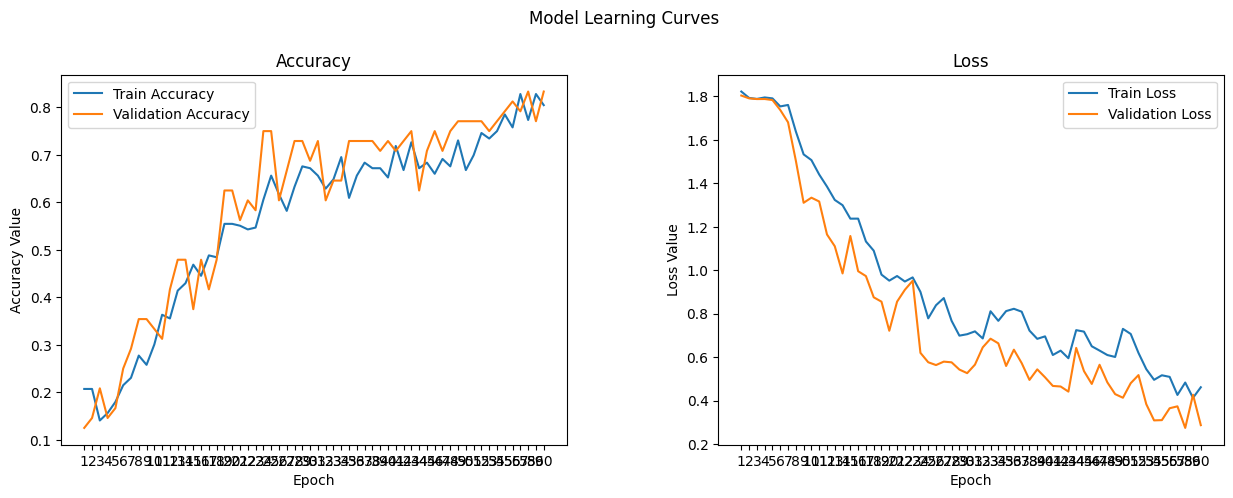

In [12]:
#----------- Your code here --------------------->
loss_fcn = "sparse_categorical_crossentropy"
optimizer_fcn = tf.keras.optimizers.Adam(learning_rate=0.0004)
metrics_fcn = ["accuracy"] # par alias

model.compile(loss=loss_fcn, optimizer=optimizer_fcn, metrics=metrics_fcn)

NB_EPOCHS = 60

cbk_matconf = ConfusionEvaluation(validation_data=(ds_val, labelInd_val))

history = model.fit(ds_train,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=ds_val,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=NB_EPOCHS,
                    callbacks=[cbk_matconf])

learningCurves(history.history, "Model Learning Curves")

#------------------------------------------------>

### 5.5 Evaluating the model

In [14]:
#----------- Your code here --------------------->
model.evaluate(ds_test)
#------------------------------------------------>

6/6 [==============================] - 0s 13ms/step - loss: 0.3687 - accuracy: 0.8444


[0.3687136769294739, 0.8444444537162781]

### 4.6 Saving the model

In [15]:
# Save model
RESULT_PATH = './results'

def save_model(model_type):
    # description
    json_finename = RESULT_PATH+'/'+model_type+"_finetunedmodel.json"
    model_finename = RESULT_PATH+'/'+model_type+"_finetunedmodel.h5"
    weights_filename = RESULT_PATH+'/'+model_type+"_finetunedweights.h5"
    hist_filename = RESULT_PATH+'/'+model_type+"_finetunedhistory.npy"


    # save json model
    model_json = model.to_json()
    with open(json_finename, "w+") as json_file:
        json_file.write(model_json)

    # save model and weights
    model.save(model_finename)

    # save weights of the model
    model.save_weights(weights_filename)
    print("Model saved to disk")

    # Fit history saving
    np.save(hist_filename, history.history)

    # with open(hist_filename, "w") as file_pi:
    #      pickle.dump(history.history, file_pi)

save_model('my_model')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to disk


**Question 5.1: Expliquez votre architecture et en particulier à quoi servent les couches (et leur enchainement) de votre architecture.**

Voici comment se compose notre architecture : 

-La couche convolutionnelle (Conv2D), elle détecte des motifs et des caractéristiques visuelles dans l'image à l'aide de filtres. Avec 32 filtres de taille 7x7, elle explore des informations de bas niveau.

-La couche de Max Pooling, après chaque couche de convolution, une couche de Max Pooling réduit les dimensions spatiales de l'image, conservant les traits saillants tout en réduisant la complexité.

-Les autres couches convolutionnelles, deux autres blocs de convolution suivent une structure similaire, mais avec un nombre croissant de filtres (64, 128, 256) pour capturer des caractéristiques de plus en plus complexes.

-La couche Flatten, cette couche transforme les données en un vecteur unidimensionnel, préparant l'entrée pour les couches entièrement connectées.

-Les couches Denses (Fully Connected), leux couches denses de 128 et 64 neurones respectivement, avec une fonction d'activation ReLU, permettent au modèle d'apprendre des représentations plus abstraites.

-Les couches de Dropout ajoutent une régularisation en désactivant aléatoirement certains neurones pendant l'entraînement, réduisant ainsi le surajustement.

-Et enfin la couche de Sortie. La dernière couche, avec une activation softmax, produit la distribution de probabilités pour chaque classe de fond marin, permettant ainsi de classer l'image.

En résumé, cette architecture utilise des convolutions pour extraire des caractéristiques visuelles, des couches de pooling pour la réduction dimensionnelle, des couches denses pour la représentation abstraite, et des couches de dropout pour la régularisation, aboutissant à une couche de sortie pour la classification.

**Question 5.2: Faites un bilan des performances obtenus.**

Les graphiques montrent que le modèle s'améliore au fil du temps, tant sur les données d'entraînement que sur celles de validation. On observe quelques variations, surtout dans les résultats de validation. Le modèle semble bien généraliser sans trop s'ajuster uniquement aux données d'entraînement. Les pics dans les résultats de validation pourraient être améliorés en ajustant certains réglages du modèle. En résumé, le modèle fonctionne assez bien, mais il y a encore des possibilités pour le rendre plus stable et potentiellement plus performant avec quelques ajustements.

## 6. Bilan des modèles appris


**Question 6.1: Comparez les performances obtenues (par rapport à celles obtenues à la partie précédente) sur la matrice de confusion et les métriques de performance classiques. Et donnez les avantages et inconvénients de chaque approche.**

Notre modèle semble s'améliorer au fil du temps en termes d'exactitude, aussi bien sur les données d'entraînement que sur celles de validation. Cependant, la précision sur les données de validation varie par moments. Les courbes de perte montrent que l'erreur du modèle diminue globalement, mais il y a des moments où cette erreur sur les données de validation augmente brièvement.

En comparant cela avec le modèle VGG16, notre modèle a une précision de test similaire, mais sa courbe de perte sur les données de validation fluctue davantage. Par rapport à InceptionV3, la précision de test est également similaire, bien que la courbe de perte sur les données de validation soit un peu moins stable. Dans l'ensemble, les modèles semblent avoir des performances similaires, mais notre modèle montre des variations plus marquées dans la perte sur les données de validation, ce qui pourrait indiquer des prédictions moins stables dans certaines situations. Des ajustements pourraient être envisagés pour rendre ces prédictions plus stables.

## 7. Fonctions d'aide éventuelle


In [6]:
# fonction d'aide pour afficher les courbes d'apprentissage

def learningCurves(history,title):
    #Learning curve plotting
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    t = f.suptitle(title, fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epochs = list(range(1,NB_EPOCHS+1))
    ax1.plot(epochs, history['accuracy'], label='Train Accuracy')
    ax1.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(epochs)
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    ax1.legend()

    ax2.plot(epochs, history['loss'], label='Train Loss')
    ax2.plot(epochs, history['val_loss'], label='Validation Loss')
    ax2.set_xticks(epochs)
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    ax2.legend()


# fonction callback (à rajouter en option à model.fit) pour suivre l'évolution de la matrice de confusion au long de l'apprentissage
# credit: K. Bedin (ROB 2020) et D. Eleye (ROB 2023) développé lors du cours
class ConfusionEvaluation(keras.callbacks.Callback):
    """
        Fonction callback pour la méthode 'fit_generator()' permettant d'afficher
        la matrice de confusion à chaque fin d'Epoch.
        Cela permet de visualiser concraitement l'évolution de la classification au cours de l'apprentissage.
    """
    def __init__(self, validation_data=()):
        super(keras.callbacks.Callback, self).__init__()
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        preds_Inception = self.model.predict(self.X_val)
        matrixInception = confusion_matrix(self.y_val,preds_Inception.argmax(axis=1))
        print("\nConfusion Matrix:")
        print(matrixInception)

# cbk_matconf = ConfusionEvaluation(validation_data=(ds_val, labelInd_val))



